In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error


import statsmodels.api as sm

In [4]:
df = pd.read_csv('CarPrice_Assignment.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

In [5]:
df.isna().sum().sum()

0

In [29]:
## saving list of numeric features to slice for pairplot
num_selector = make_column_selector(dtype_include='number')
cols = num_selector(df.drop(columns='price'))
len(cols)



15

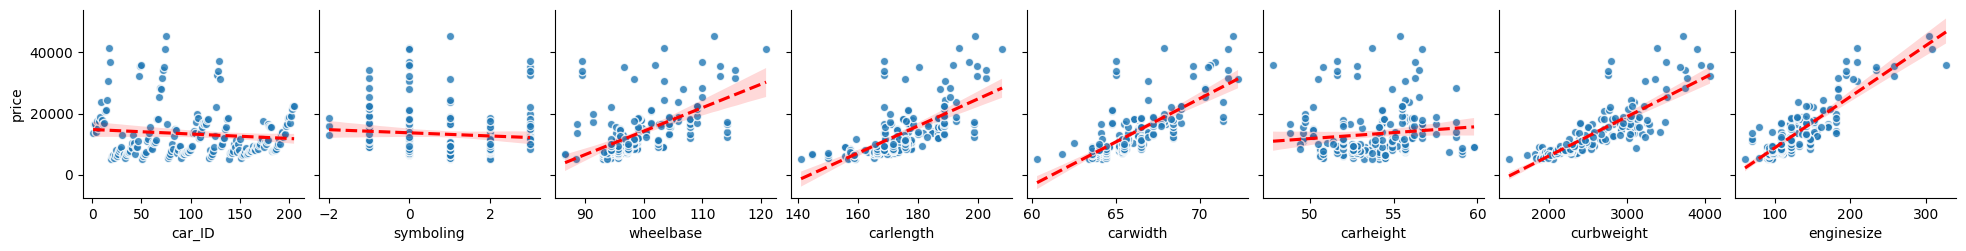

In [30]:
## Quick EDA for cols related to target

sns.pairplot(df, x_vars=cols[:8] , y_vars='price',kind='reg', 
             plot_kws= dict( line_kws={'color':'red', 'ls':'--'}, scatter_kws={'edgecolor':'white','lw':1}));

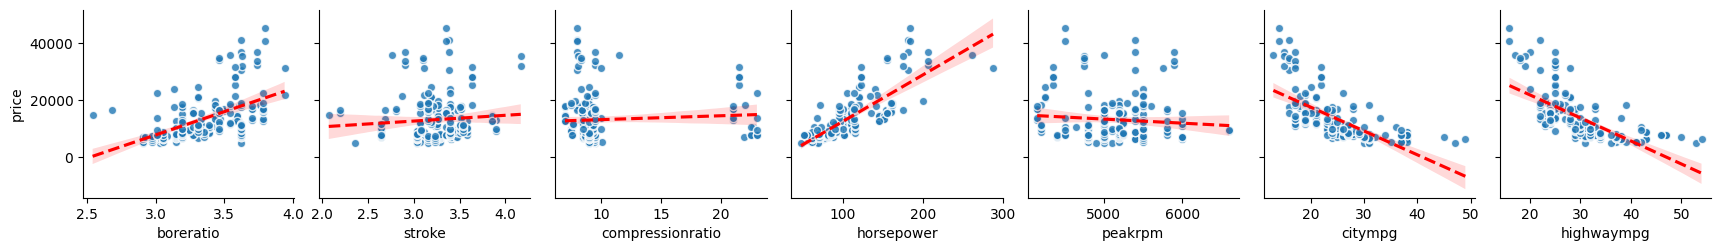

In [31]:
## Quick EDA for cols related to target

sns.pairplot(df, x_vars=cols[8:] , y_vars='price',kind='reg', 
             plot_kws= dict( line_kws={'color':'red', 'ls':'--'}, scatter_kws={'edgecolor':'white','lw':1}));

In [32]:
#drop variables that don't have a linear relationship to our target,

df_linear = df.drop(columns=['compressionratio', 'stroke', 'peakrpm', 'car_ID', 'symboling'])
df_linear.shape

(205, 21)

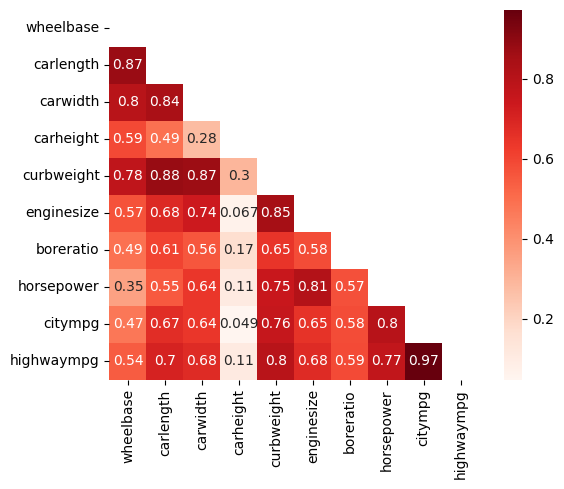

In [36]:
## Calc abs values of correlations
corr = df_linear.drop(columns='price').corr().abs()
mask= np.triu(np.ones_like(corr))
sns.heatmap(corr, square=True, cmap='Reds', annot=True, mask=mask);

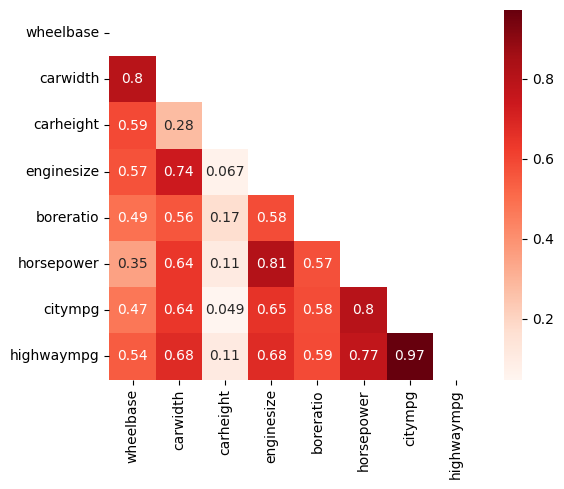

In [40]:
#dropping curbweight for multicolinearity with many other features
## Calc abs values of correlations
corr = df_linear.drop(columns=['price', 'curbweight', 'carlength']).corr().abs()
mask= np.triu(np.ones_like(corr))
sns.heatmap(corr, square=True, cmap='Reds', annot=True, mask=mask);

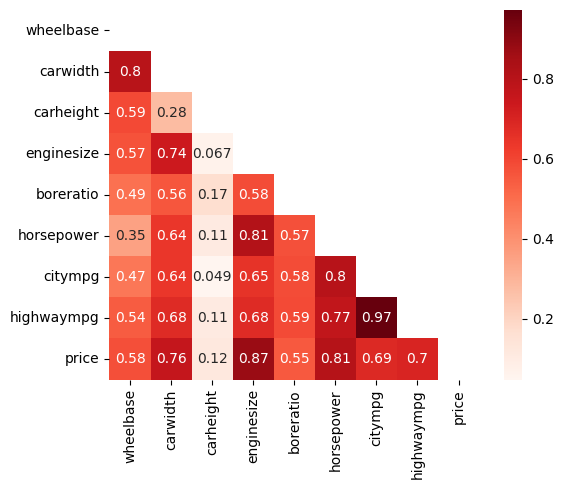

In [41]:
## to decide wich one to drop we will add price back (comparing: citympg vs highwaympg , engisize vs horse power, )
df_linear = df_linear.drop(columns=['curbweight', 'carlength'])
corr = df_linear.corr().abs()
mask= np.triu(np.ones_like(corr))
sns.heatmap(corr, square=True, cmap='Reds', annot=True, mask=mask);

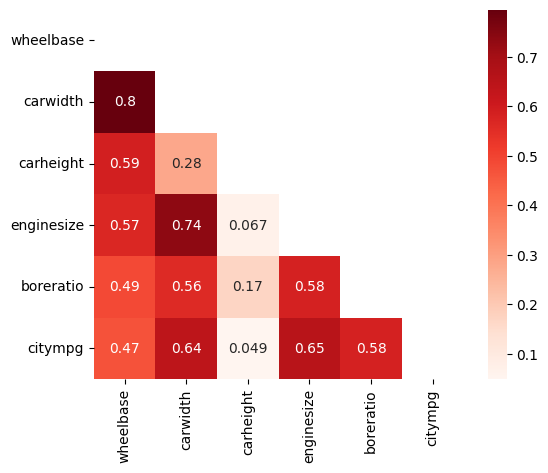

In [42]:
df_linear = df_linear.drop(columns=['horsepower', 'highwaympg'])

#last check

corr = df_linear.drop(columns='price').corr().abs()
mask= np.triu(np.ones_like(corr))
sns.heatmap(corr, square=True, cmap='Reds', annot=True, mask=mask);

In [44]:
# Modeling
## Make x and y variables
y = df_linear['price'].copy()
X = df_linear.copy()
X_train,X_test, y_train, y_test = train_test_split(X,y, random_state=42)
X_train.head()

,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carwidth,carheight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,citympg,price
90,nissan gt-r,diesel,std,two,sedan,fwd,front,94.5,63.8,54.5,ohc,four,103,idi,2.99,45,7099.0
173,toyota corolla,gas,std,four,sedan,fwd,front,102.4,66.5,54.9,ohc,four,122,mpfi,3.31,29,8948.0
93,nissan titan,gas,std,four,wagon,fwd,front,94.5,63.8,53.5,ohc,four,97,2bbl,3.15,31,7349.0
5,audi fox,gas,std,two,sedan,fwd,front,99.8,66.3,53.1,ohc,five,136,mpfi,3.19,19,15250.0
167,toyota corona liftback,gas,std,two,hardtop,rwd,front,98.4,65.6,52.0,ohc,four,146,mpfi,3.62,24,8449.0


In [45]:
## make cat selector and using it to save list of column names
cat_select = make_column_selector(dtype_include='object')
cat_cols = cat_select(X_train)

## make num selector and using it to save list of column names
num_select = make_column_selector(dtype_include='number')
num_cols = num_select(X_train)

In [46]:
## make only encoders/scalers because there isn't a missing value 
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
#imp = SimpleImputer(strategy='mean')
#scaler = StandardScaler()

preprocessor = make_column_transformer((ohe,cat_cols)
                                        #,(scaler, num_cols)
                                            , remainder='passthrough')

In [47]:
## fit the col transformer
preprocessor.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 ['CarName', 'fueltype', 'aspiration',
                                  'doornumber', 'carbody', 'drivewheel',
                                  'enginelocation', 'enginetype',
                                  'cylindernumber', 'fuelsystem'])])

In [48]:
pd.DataFrame(preprocessor.transform(X_train).round(2))

,0,1,2,3,4,5,6,7,8,9,...,152,153,154,155,156,157,158,159,160,161
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,94.5,63.8,54.5,103.0,2.99,45.0,7099.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,102.4,66.5,54.9,122.0,3.31,29.0,8948.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,94.5,63.8,53.5,97.0,3.15,31.0,7349.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,99.8,66.3,53.1,136.0,3.19,19.0,15250.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,98.4,65.6,52.0,146.0,3.62,24.0,8449.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,99.2,67.9,49.7,181.0,3.43,19.0,18399.0
149,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,103.5,66.9,55.7,164.0,3.31,20.0,24565.0
150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,94.5,63.8,54.5,97.0,3.15,31.0,6849.0
151,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,102.9,67.7,52.0,171.0,3.27,19.0,15998.0


In [49]:
#getting columns names
fit_ohe = pd.DataFrame(ohe.fit_transform(X_train[cat_cols]))

In [50]:
names= []
names.extend(ohe.get_feature_names_out())
len(names)

155

In [51]:
names.extend(num_cols)
len(names)

162

In [52]:
#transforming df's
X_train_df = pd.DataFrame( preprocessor.transform(X_train), columns=names, index=X_train.index)
X_train_df.head()



,CarName_Nissan versa,CarName_alfa-romero Quadrifoglio,CarName_alfa-romero giulia,CarName_alfa-romero stelvio,CarName_audi 100 ls,CarName_audi 100ls,CarName_audi 4000,CarName_audi 5000,CarName_audi fox,CarName_bmw 320i,...,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi,wheelbase,carwidth,carheight,enginesize,boreratio,citympg,price
90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,94.5,63.8,54.5,103.0,2.99,45.0,7099.0
173,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,102.4,66.5,54.9,122.0,3.31,29.0,8948.0
93,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,94.5,63.8,53.5,97.0,3.15,31.0,7349.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,99.8,66.3,53.1,136.0,3.19,19.0,15250.0
167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,98.4,65.6,52.0,146.0,3.62,24.0,8449.0


In [53]:
X_test_df = pd.DataFrame(preprocessor.transform(X_test), columns=names, index=X_test.index)
X_test_df.head()



,CarName_Nissan versa,CarName_alfa-romero Quadrifoglio,CarName_alfa-romero giulia,CarName_alfa-romero stelvio,CarName_audi 100 ls,CarName_audi 100ls,CarName_audi 4000,CarName_audi 5000,CarName_audi fox,CarName_bmw 320i,...,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi,wheelbase,carwidth,carheight,enginesize,boreratio,citympg,price
15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,103.5,66.9,55.7,209.0,3.62,16.0,30760.000
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,99.5,67.9,52.0,131.0,3.13,16.0,17859.167
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,97.2,65.2,54.7,120.0,3.33,27.0,9549.000
132,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,99.1,66.5,56.1,121.0,3.54,21.0,11850.000
68,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,110.0,70.3,58.7,183.0,3.58,22.0,28248.000


In [54]:
## adding a constant to X_train (not rewriting the df yet-confirming expected results first)

X_train_df = sm.add_constant(X_train_df,has_constant='add', prepend=False)
X_test_df = sm.add_constant(X_test_df,has_constant='add', prepend=False)
display(X_train_df.head(2), X_test_df.head(2))



,CarName_Nissan versa,CarName_alfa-romero Quadrifoglio,CarName_alfa-romero giulia,CarName_alfa-romero stelvio,CarName_audi 100 ls,CarName_audi 100ls,CarName_audi 4000,CarName_audi 5000,CarName_audi fox,CarName_bmw 320i,...,fuelsystem_spdi,fuelsystem_spfi,wheelbase,carwidth,carheight,enginesize,boreratio,citympg,price,const
90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,94.5,63.8,54.5,103.0,2.99,45.0,7099.0,1.0
173,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,102.4,66.5,54.9,122.0,3.31,29.0,8948.0,1.0


,CarName_Nissan versa,CarName_alfa-romero Quadrifoglio,CarName_alfa-romero giulia,CarName_alfa-romero stelvio,CarName_audi 100 ls,CarName_audi 100ls,CarName_audi 4000,CarName_audi 5000,CarName_audi fox,CarName_bmw 320i,...,fuelsystem_spdi,fuelsystem_spfi,wheelbase,carwidth,carheight,enginesize,boreratio,citympg,price,const
15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,103.5,66.9,55.7,209.0,3.62,16.0,30760.000,1.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,99.5,67.9,52.0,131.0,3.13,16.0,17859.167,1.0


In [55]:
#instantiating model

model = sm.OLS(y_train, X_train_df, hasconst=True)


In [56]:
# Fitting the model (no data in .fit) and saving the result as new var
result = model.fit()


In [57]:
## get model performance metrics
result.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.100e+27
Date:                Sun, 16 Oct 2022   Prob (F-statistic):          2.24e-174
Time:                        15:29:10   Log-Likelihood:                 3354.8
No. Observations:                 153   AIC:                            -6430.
Df Residuals:                      13   BIC:                            -6005.
Df Model:                         139                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
CarName_Nissan versa                     9.095e-12   3.11e-10      0.029      0.977   -6.63e-10    6.81e-10
CarName_alfa-romero Quadrifoglio        -7.276e-12   4.99e-10     -0.015      0.989   -1.09e-09    1.07e-09
CarName_alfa-romero giulia              -1.091e-11    4.2e-10     -0.026      0.980   -9.19e-10    8.97e-10
CarName_alfa-romero stelvio             -1.637e-11   4.17e-10     -0.039      0.969   -9.16e-10    8.84e-10
CarName_audi 100 ls                              0   2.92e-10          0      1.000    -6.3e-10     6.3e-10
CarName_audi 100ls                       1.455e-11   3.25e-10      0.045      0.965   -6.88e-10    7.17e-10
CarName_audi 4000                       -1.819e-12   4.15e-10     -0.004      0.997   -8.99e-10    8.95e-10
CarName_audi 5000                        2.728e-12   4.01e-10      0.007      0.995   -8.64e-10    8.69e-10
CarName_audi fox                         1.091e-11   5.32e-10      0.021      0.984   -1.14e-09    1.16e-09
CarName_bmw 320i                        -1.819e-11   5.93e-10     -0.031      0.976    -1.3e-09    1.26e-09
CarName_bmw x1                           5.457e-12    6.2e-10      0.009      0.993   -1.33e-09    1.35e-09
CarName_bmw x3                          -5.457e-12   5.99e-10     -0.009      0.993    -1.3e-09    1.29e-09
CarName_bmw z4                           1.819e-11   6.54e-10      0.028      0.978   -1.39e-09    1.43e-09
CarName_buick opel isuzu deluxe             -1e-11   5.57e-10     -0.018      0.986   -1.21e-09    1.19e-09
CarName_buick regal sport coupe (turbo)  1.455e-11   4.38e-10      0.033      0.974   -9.31e-10    9.61e-10
CarName_buick skyhawk                   -1.091e-11   7.45e-10     -0.015      0.989   -1.62e-09     1.6e-09
CarName_buick skylark                       -1e-11   2.62e-10     -0.038      0.970   -5.76e-10    5.56e-10
CarName_chevrolet vega 2300              8.185e-12   3.88e-10      0.021      0.983    -8.3e-10    8.46e-10
CarName_dodge challenger se             -3.638e-12   3.75e-10     -0.010      0.992   -8.15e-10    8.07e-10
CarName_dodge colt (sw)                 -2.547e-11   3.73e-10     -0.068      0.947   -8.31e-10     7.8e-10
CarName_dodge coronet custom             3.638e-12   4.96e-10      0.007      0.994   -1.07e-09    1.07e-09
CarName_dodge d200                       3.638e-12   4.51e-10      0.008      0.994    -9.7e-10    9.78e-10
CarName_dodge dart custom                2.001e-11   4.88e-10      0.041      0.968   -1.03e-09    1.07e-09
CarName_dodge rampage                    1.273e-11   4.34e-10      0.029      0.977   -9.25e-10     9.5e-10
CarName_honda accord                    -3.092e-11   7.45e-10     -0.041      0.968   -1.64e-09    1.58e-09
CarName_honda accord cvcc               -1.819e-11   6.21e-

In [58]:
# after fitting statsmodels, use the result variable with .predict()
test_preds = result.predict(X_test_df)


In [59]:
print('Testing r2:', r2_score(y_test, test_preds))



Testing r2: 1.0


In [60]:
# To get our residuals from statsmodels and preview first 5
resid = result.resid
resid.head()

90     9.640644e-11
173    8.731149e-11
93     4.820322e-11
5      6.730261e-11
167    9.094947e-11
dtype: float64

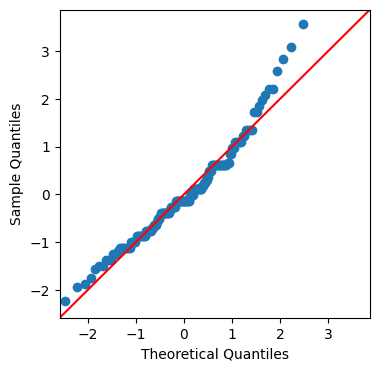

In [61]:
fig, ax = plt.subplots(figsize=(4, 4))
sm.graphics.qqplot(resid,line='45',fit=True, ax=ax);

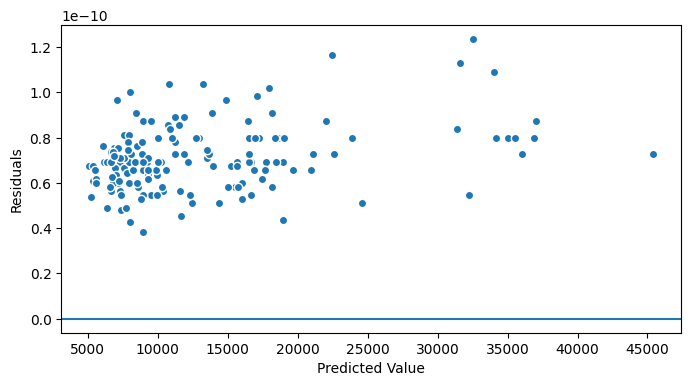

In [64]:
## Get predictions and calculate residuals
y_pred = result.predict(X_train_df)
resid = y_train -  y_pred
## Plot predicitons vs resids
fig, ax = plt.subplots(figsize=(8,4))
ax.scatter(y_pred,resid,ec='white',lw=1)
ax.axhline(0)
ax.set(ylabel='Residuals',xlabel='Predicted Value');

In [66]:
#to remove outiers we will scale/flatten and use z-scor:

scaler = StandardScaler()
z_price = scaler.fit_transform(y_train.values.reshape(-1,1))
z_price[:5]

array([[-0.7956461 ],
       [-0.56095133],
       [-0.76391344],
       [ 0.23896561],
       [-0.62428972]])

In [67]:
z_price = pd.Series(z_price.flatten(),index=y_train.index )
z_price[:5]

90    -0.795646
173   -0.560951
93    -0.763913
5      0.238966
167   -0.624290
dtype: float64

In [69]:
idx_outliers= z_price>3
idx_outliers[:5]

90     False
173    False
93     False
5      False
167    False
dtype: bool

In [70]:
y_train_cln = y_train[~idx_outliers]
X_train_cln = X_train_df[~idx_outliers]

In [71]:
print(f"Our model includes cars priced:")
print(f"- Greater than ${y_train_cln.min():,.2f}")
print(f"- Less than ${y_train_cln.max():,.2f}")

Our model includes cars priced:
- Greater than $5,118.00
- Less than $36,880.00


In [78]:
# Getting scaled y_test
z_price_test = scaler.transform(y_test.values.reshape(-1,1))
z_price_test = pd.Series(z_price_test.flatten(),index=y_test.index )
# saving the true/false result as our outlier index
idx_outliers_test= z_price_test>3
# how many outleirs in test data?
idx_outliers_test.sum()

2

In [79]:
## make clean version of X_test and y_test
X_test_cln = X_test_df[~idx_outliers_test] 
y_test_cln = y_test[~idx_outliers_test]

In [80]:
## make & fit a statmsodels OLS
model = sm.OLS(y_train_cln,X_train_cln)
result = model.fit()
print(result.summary())


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.154e+26
Date:                Sun, 16 Oct 2022   Prob (F-statistic):          9.02e-170
Time:                        15:41:19   Log-Likelihood:                 3199.7
No. Observations:                 151   AIC:                            -6123.
Df Residuals:                      13   BIC:                            -5707.
Df Model:                         137                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

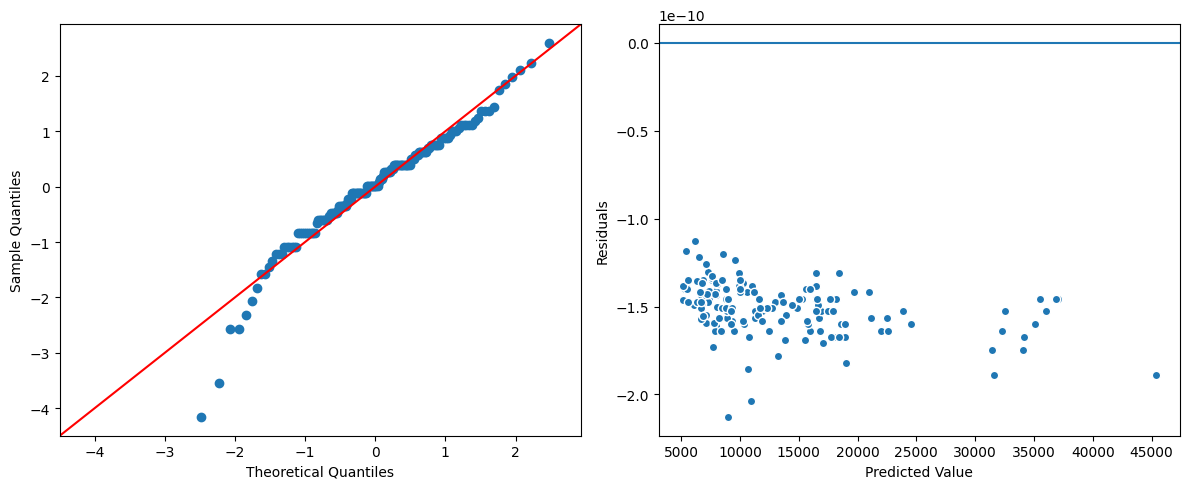

In [81]:
def evaluate_ols(result,X_train_df, y_train):
    """Plots a Q-Q Plot and residual plot for a statsmodels OLS regression.
    """
    
    ## save residuals from result
    y_pred = result.predict(X_train_df)
    resid = y_train - y_pred
    
    fig, axes = plt.subplots(ncols=2,figsize=(12,5))
    
    ## Normality 
    sm.graphics.qqplot(resid,line='45',fit=True,ax=axes[0]);
    
    ## Homoscedasticity
    ax = axes[1]
    ax.scatter(y_pred, resid, edgecolor='white',lw=1)
    ax.axhline(0,zorder=0)
    ax.set(ylabel='Residuals',xlabel='Predicted Value');
    plt.tight_layout()
    
evaluate_ols(result,X_train_df, y_train)

In [82]:
## save p-values
p_vals = result.pvalues
## filter for p_values that are >.05
p_vals[p_vals>.05]

CarName_Nissan versa                0.969106
CarName_alfa-romero Quadrifoglio    0.988734
CarName_alfa-romero giulia          0.996039
CarName_alfa-romero stelvio         0.995563
CarName_audi 100 ls                 0.997644
                                      ...   
carheight                           0.983989
enginesize                          0.979035
boreratio                           0.991123
citympg                             0.964741
const                               0.986171
Length: 161, dtype: float64

In [83]:
## so how many CarName columns do we have overall? 
# use a list comprehension to filter out column sthat start with zipcode
CarName_cols = [col for col in X_train_df.columns if col.startswith('CarName')]
## preview first few zipcode cols to confirm
CarName_cols[:3]

['CarName_Nissan versa',
 'CarName_alfa-romero Quadrifoglio',
 'CarName_alfa-romero giulia']

In [84]:
len(CarName_cols)

119

In [96]:
to_remove = p_vals[p_vals>.05]
list_car = list(to_remove.index)
list_car[:5]

['CarName_Nissan versa',
 'CarName_alfa-romero Quadrifoglio',
 'CarName_alfa-romero giulia',
 'CarName_alfa-romero stelvio',
 'CarName_audi 100 ls']

In [95]:
car_name_remove = [name for name in list_car if name.startswith('CarName')]

In [97]:
len(car_name_remove)

118